In [34]:
import librosa
import librosa.display
import numpy as np
import matplotlib.pyplot as plt
import os, sys, copy, time, csv, pickle, PIL

import sklearn
from sklearn import tree as tr
from sklearn import ensemble as ens
from sklearn import model_selection as ms
from sklearn import linear_model as lm
from sklearn import metrics as mt

import hyperopt as hpt
from hyperopt import hp, tpe
from hyperopt.fmin import fmin

import shap

## Data load (data has been already transformed into tabular feature form)

In [45]:
def DataLoad(name):
  ff = open(name, 'r')
  rdr = csv.reader(ff)
  data0 = [row for row in rdr]
  data = np.array(data0[1:])[:, 1:].astype(float)
  ff.close()
  return data

In [94]:
data_bad = DataLoad(r'dataset_bad_new.csv')
data_good = DataLoad(r'dataset_good_new.csv')
data_bad_new = DataLoad(r'dataset_bad1_upd.csv')
data_good_new = DataLoad(r'dataset_good1_upd.csv')

X = np.concatenate([data_bad, data_good, data_bad_new, data_good_new], axis = 0)
Y = np.array(data_bad.shape[0]*[0] + data_good.shape[0]*[1] + data_bad_new.shape[0]*[0] + data_good_new.shape[0]*[1])
all_ = np.concatenate([X, np.expand_dims(Y, axis = -1)], axis = -1)

np.random.shuffle(all_)

all_train = all_[:-int(X.shape[0]*0.3)]
all_test = all_[-int(X.shape[0]*0.3):]

X_tr = all_train[:, :-1]
Y_tr = all_train[:, -1]
X_te = all_test[:, :-1]
Y_te = all_test[:, -1]

(array([ 2517.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0., 23912.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 10 Patch objects>)

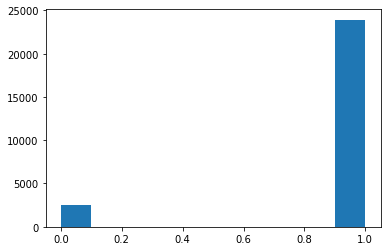

In [122]:
plt.hist(Y_tr)

## Model training(load) and testing

In [162]:
def sigmoidmy(x):
  return (1/(1 + np.exp(-x)) - 0.5)*2

def TPFPTNFN(y, y_pred):
    d = {'TP': 0, 'FP': 0, 'TN': 0, 'FN': 0}
    for i in range(len(y)):
        if (y[i]==1) and (y_pred[i]==1): d['TP'] = d['TP'] + 1 
        if (y[i]==1) and (y_pred[i]==0): d['FN'] = d['FN'] + 1 
        if (y[i]==0) and (y_pred[i]==1): d['FP'] = d['FP'] + 1 
        if (y[i]==0) and (y_pred[i]==0): d['TN'] = d['TN'] + 1 
    return d

def MetricAlgo(est, X, Y, hyper=8):
  prom = TPFPTNFN(Y, est.predict(X))
  prom1 = 1 - mt.roc_auc_score(Y, est.predict(X))
  prom2 = (prom['FN']*hyper + prom['FP'] + 10e-6)
  current_score = prom2*prom1
  return current_score

def FBloss(est, X, Y, beta=10):
  current_score = mt.fbeta_score(Y, est.predict(X), beta=beta)
  return 1 - current_score

In [ ]:
N = 100
LL = [{0: 0.3 + 0.7*i/N, 1: 0.7*(N-i)/N} for i in  range(N)]

def Tree_score(params):
    TR = tr.DecisionTreeClassifier(**params)
    current_score = ms.cross_val_score(TR, X_tr, Y_tr, scoring=MetricAlgo, cv=10).mean()
    return current_score
 
 
tree_params = {
            'criterion': hp.choice('criterion', ['gini', 'entropy']),
            'max_depth': hp.choice('max_depth', range(5, 30)),
            'min_samples_split':  hp.choice('min_samples_split', range(5, 10)),
            'min_samples_leaf': hp.choice('min_samples_leaf', range(5, 10)),
            'class_weight': hp.choice('class_weight', ['balanced']+LL)
}
 
TRbest = fmin(fn=Tree_score, space=tree_params, max_evals=25, algo=hpt.rand.suggest, return_argmin=True)
print('\nBest:')
print(TRbest) 

 12%|█▏        | 3/25 [00:33<04:13, 11.50s/it, best loss: 389.001865602787]

In [148]:
TR = tr.DecisionTreeClassifier(criterion = ['gini', 'entropy'][TRbest['criterion']],
                               max_depth = list(range(2, 50))[TRbest['max_depth']],
                               min_samples_leaf = list(range(2, 20))[TRbest['min_samples_leaf']],
                               min_samples_split = list(range(2, 10))[TRbest['min_samples_split']],
                               class_weight = (['balanced']+LL)[TRbest['class_weight']],
                              )
TR.fit(X_tr, Y_tr)

DecisionTreeClassifier(ccp_alpha=0.0,
                       class_weight={0: 0.9509999999999998,
                                     1: 0.048999999999999995},
                       criterion='entropy', max_depth=13, max_features=None,
                       max_leaf_nodes=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=5,
                       min_samples_split=6, min_weight_fraction_leaf=0.0,
                       presort='deprecated', random_state=None,
                       splitter='best')

ROCAUCtr: 0.8032994656077715
ROCAUCte: 0.6157865464277347
{'TP': 14809, 'FP': 32, 'TN': 2485, 'FN': 9103}


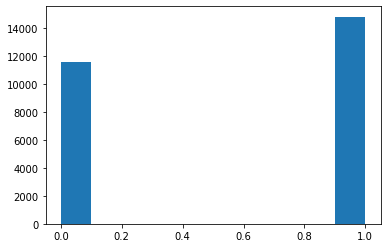

In [149]:
plt.hist(TR.predict(X_tr))
print('ROCAUCtr:', mt.roc_auc_score(Y_tr, TR.predict(X_tr)))
print('ROCAUCte:', mt.roc_auc_score(Y_te, TR.predict(X_te)))
print(TPFPTNFN(Y_tr, TR.predict(X_tr)))

In [157]:
MetricAlgo(TR, X_tr, Y_tr, hyper=10)

2.0


2.1967005343922286

In [ ]:
def Bag_score(params):
    BA = ens.BaggingClassifier(**params)
    current_score = ms.cross_val_score(BA, X_tr, Y_tr, scoring=MetricAlgo, cv=10).mean()
    return current_score

bag_params = {
            'base_estimator': hp.choice('base_estimator', [TR, ]),
            'n_estimators': hp.choice('n_estimators', range(10, 30)),
            'max_features':  hp.choice('max_features', np.arange(0.5, 1, 0.1)),
            'max_samples':  hp.choice('max_samples', np.arange(0.5, 1, 0.1))
}
 
BAbest = fmin(fn=Bag_score, space=bag_params, max_evals=10, algo=hpt.rand.suggest, return_argmin=True) #~100
print('\nBest:')
print(BAbest) 

In [91]:
BA = ens.BaggingClassifier(base_estimator=TR,
                           n_estimators=range(2, 30)[BAbest['n_estimators']],
                           max_features = np.arange(0.4, 1+0.1, 0.1)[BAbest['max_features']], )

0.6097492602459875


In [ ]:
plt.hist(BA.predict(X_tr))
print('ROCAUCtr:', mt.roc_auc_score(Y_tr, BA.predict(X_tr)))
print('ROCAUCte:', mt.roc_auc_score(Y_te, BA.predict(X_te)))

## Feature importance

In [ ]:
W_forest_new = pickle.loads(pickle.load(open(r'last_model.pkl', 'rb')))
DF = pd.DataFrame(X_tr, columns=Header)
#W_forest_new

In [ ]:
# Tree on Random Forest explainer
explainerRF = shap.TreeExplainer(W_forest_new)
shap_values_RF_train = explainerRF.shap_values(DF)

In [ ]:
shap.initjs()
shap.summary_plot(shap_values_RF_test[0], DF)

In [ ]:
shp_plt = shap.dependence_plot("mfcc2", shap_values_RF_train1[0], DF)

In [ ]:
J = 105
shap.initjs()
shap.force_plot(explainerRF1.expected_value[0], shap_values_RF_train1[0][J], DF.iloc[[J]])